In [213]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

data = pd.read_csv("Jurcsik_Kovacs_1996_table1(in).csv")


# data filter
df = data.drop(columns=["shifted_data","star_name", "N", "sigma"])

df

,period,A0,A1,phi1,A2,phi2,A3,phi3,A4,phi4,...,phi11,A12,phi12,A13,phi13,a14,phi14,A15,phi15,metallicity
0,0.442266,9.730,0.3218,0.0179,0.1803,2.6140,0.1057,5.4850,0.0590,2.0787,...,5.5635,0.0044,1.9820,0.0058,4.6203,0.0051,0.7701,0.0044,3.6286,-0.06
1,0.722753,10.739,0.3358,1.6476,0.1720,5.9663,0.1134,4.0763,0.0617,2.5336,...,1.7614,0.0006,1.7596,0.0013,0.5223,0.0011,5.6820,0.0012,4.6372,-1.69
2,0.616915,10.722,0.2000,1.5871,0.0795,5.8195,0.0399,3.9177,0.0192,2.1835,...,3.6049,0.0008,1.2567,0.0009,5.3117,0.0007,3.8731,0.0008,1.9359,-0.92
3,0.574337,10.892,0.3241,2.9349,0.1425,1.9110,0.1110,1.1494,0.0745,0.5286,...,4.1754,0.0048,3.5231,0.0061,3.0121,0.0056,2.3907,0.0050,1.7239,-1.39
4,0.459303,11.294,0.4646,1.8951,0.2167,6.0193,0.1610,4.1492,0.0980,2.3481,...,2.3529,0.0080,0.6458,0.0050,5.6980,0.0048,2.3401,0.0009,0.6272,-1.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.557657,9.849,0.3281,2.9453,0.1658,1.9827,0.1162,1.4013,0.0748,0.8343,...,4.8732,0.0038,4.3968,0.0046,3.8138,0.0050,3.2229,0.0051,2.6125,-1.15
80,0.475607,10.627,0.3756,1.3720,0.2054,5.1373,0.1310,2.9590,0.0938,0.8321,...,3.3662,0.0046,0.6953,0.0034,4.6167,0.0018,2.0494,0.0011,5.7768,-0.60
81,0.525791,11.423,0.4131,4.8677,0.1731,5.7203,0.1417,0.3700,0.1022,1.5990,...,2.7926,0.0102,3.8922,0.0096,5.0910,0.0088,0.0597,0.0077,1.3509,-1.54
82,0.656908,11.842,0.2718,0.7286,0.1335,4.0737,0.0822,1.4576,0.0426,5.1255,...,0.8733,0.0028,4.4377,0.0014,1.3375,0.0010,4.4196,0.0009,1.7312,-1.02


In [214]:
X = df.drop("metallicity", axis=1)

y = df["metallicity"]



In [215]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

model = LinearRegression()
model.fit(x_train, y_train)


,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


# Display weight of each parameter

In [216]:
coefficients = model.coef_
intercept = model.intercept_


coef_df = pd.DataFrame({'Params': list(X), 'Coefficients':coefficients})
coef_df

,Params,Coefficients
0,period,-5.209544
1,A0,0.002931
2,A1,-6.048681
3,phi1,0.016078
4,A2,10.330475
5,phi2,-0.036709
6,A3,-8.973376
7,phi3,0.035802
8,A4,20.028753
9,phi4,-0.022198


# Predict metallicity and display predicted values v. actual values

0.28988913992363263
0.12639303439195648
[-5.20954378e+00  2.93138453e-03 -6.04868058e+00  1.60780965e-02
  1.03304746e+01 -3.67094606e-02 -8.97337582e+00  3.58016496e-02
  2.00287527e+01 -2.21983145e-02 -3.64325842e+01 -3.90906140e-02
  6.12252084e+01 -2.91883166e-02 -3.72558424e+01 -3.31458740e-02
 -2.48767396e+01 -4.34367337e-02  2.84957810e+01 -2.16421460e-02
 -5.71938875e+01 -2.59137301e-02  2.35401098e+01 -3.30123512e-03
 -1.02156489e+01 -2.77214092e-02  1.19171189e+01 -2.68104539e-02
  4.38603337e+01 -9.24261969e-04 -4.60176438e+01 -9.59203143e-03]
0.5077960064003538


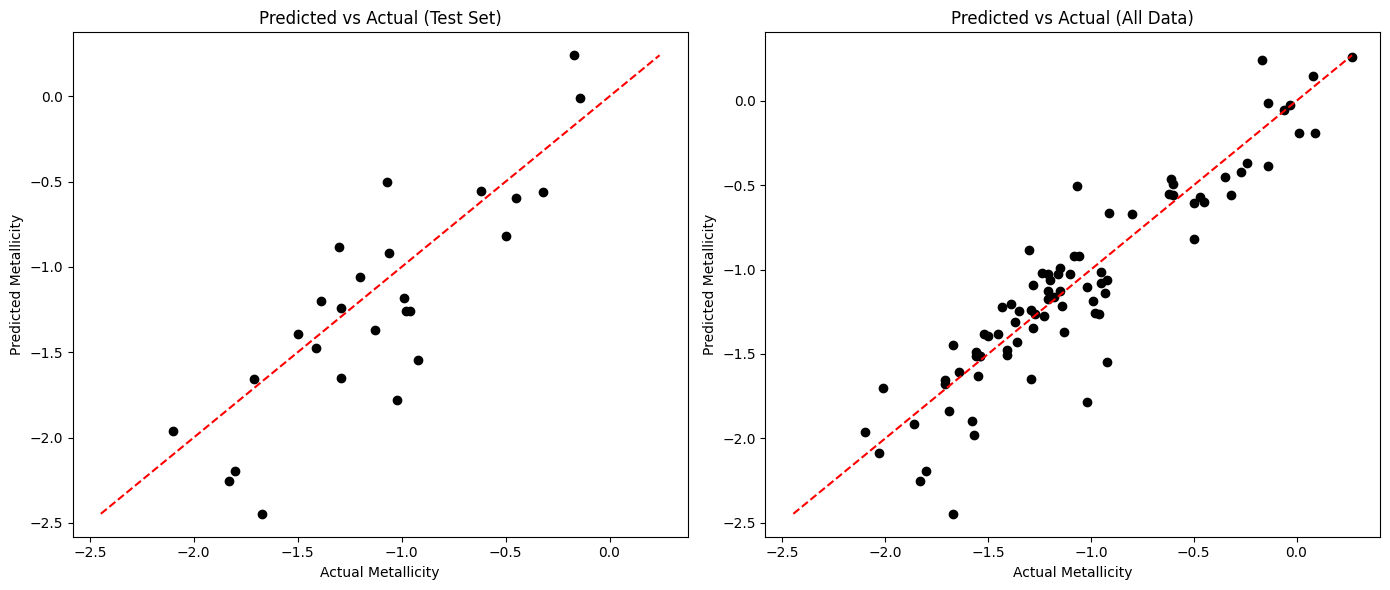

In [217]:
y_predict_test = model.predict(x_test)
y_predict_all = model.predict(X)

print(mean_absolute_error(y_test, y_predict_test))

print(mean_squared_error(y_test, y_predict_test))

print(model.coef_)
print(model.score(x_test, y_test))



fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(y_test, y_predict_test, color="black")
lims_test = [
    min(y_test.min(), y_predict_test.min()), max(y_test.max(), y_predict_test.max())
    ]
axes[0].plot(lims_test, lims_test, 'r--')
axes[0].set_xlabel("Actual Metallicity")
axes[0].set_ylabel("Predicted Metallicity")
axes[0].set_title("Predicted vs Actual (Test Set)")


axes[1].scatter(y, y_predict_all, color="black")
lims_all = [min(y.min(), y_predict_all.min()), max(y.max(), y_predict_all.max())]
axes[1].plot(lims_all, lims_all, 'r--')
axes[1].set_xlabel("Actual Metallicity")
axes[1].set_ylabel("Predicted Metallicity")
axes[1].set_title("Predicted vs Actual (All Data)")

plt.tight_layout()
plt.show()

Was 5.4313 and now is 5.4313.
Was -0.8665000000000003 and now is 5.416685307179586.
Was -0.8436000000000003 and now is 5.439585307179586.
Was -7.6553 and now is 4.911070614359172.
Was -1.5360999999999994 and now is 4.747085307179587.
Was 4.708600000000001 and now is 4.708600000000001.
Was -0.9659000000000002 and now is 5.317285307179586.
Was -0.9677000000000007 and now is 5.315485307179586.
Was -7.422999999999999 and now is 5.143370614359173.
Was -7.451800000000001 and now is 5.114570614359171.
Was -1.0186000000000002 and now is 5.264585307179586.
Was -13.8427 and now is 5.006855921538758.
Was -1.2088 and now is 5.074385307179586.
Was -13.8704 and now is 4.979155921538759.
Was -13.5196 and now is 5.329955921538758.
Was -1.3934000000000002 and now is 4.8897853071795865.
Was -7.638099999999999 and now is 4.928270614359174.
Was -7.4876 and now is 5.078770614359173.
Was 5.204700000000001 and now is 5.204700000000001.
Was -1.0050999999999997 and now is 5.278085307179587.
Was -1.492099999999

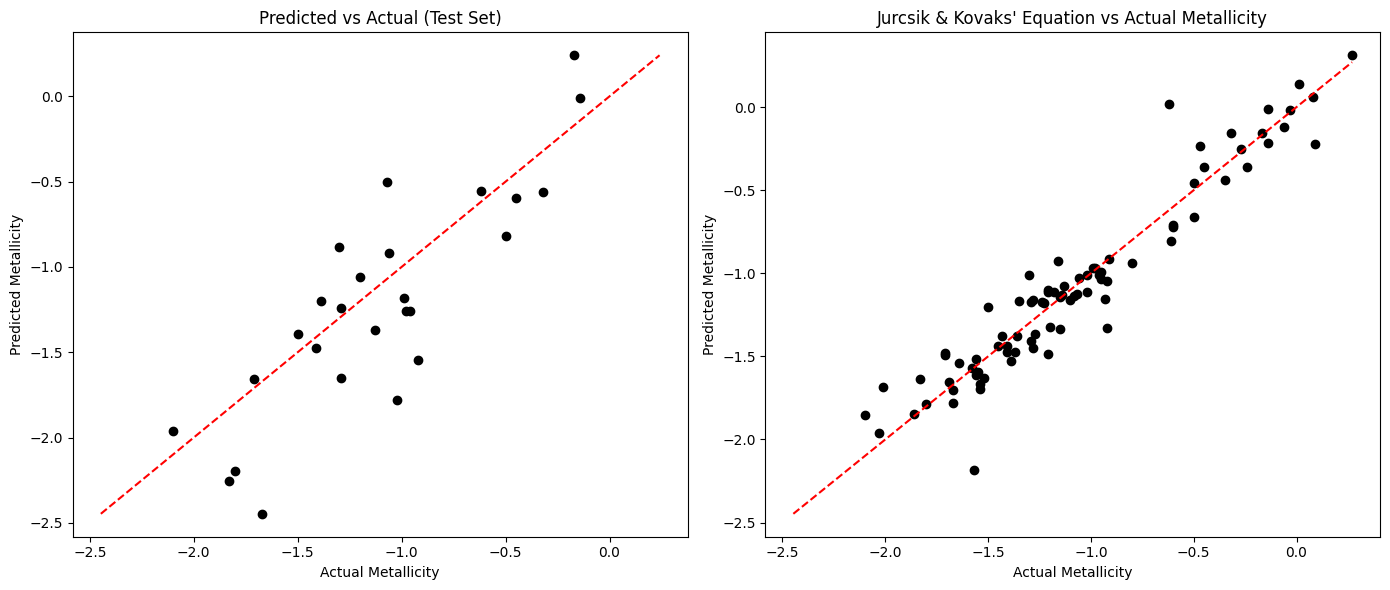

In [218]:
import blink_util

Fe_on_H = blink_util.get_FoH(df)


fig, axes = plt.subplots(1, 2, figsize=(14, 6))



axes[0].scatter(y_test, y_predict_test, color="black")
lims_test = [
    min(y_test.min(), y_predict_test.min()), max(y_test.max(), y_predict_test.max())
    ]
axes[0].plot(lims_test, lims_test, 'r--')
axes[0].set_xlabel("Actual Metallicity")
axes[0].set_ylabel("Predicted Metallicity")
axes[0].set_title("Predicted vs Actual (Test Set)")

axes[1].scatter(y, Fe_on_H, color="black")
lims_all = [min(y.min(), y_predict_all.min()), max(y.max(), y_predict_all.max())]
axes[1].plot(lims_all, lims_all, 'r--')
axes[1].set_xlabel("Actual Metallicity")
axes[1].set_ylabel("Predicted Metallicity")
axes[1].set_title("Jurcsik & Kovaks' Equation vs Actual Metallicity")

plt.tight_layout()
plt.show()

# Cross Validation
Here we use KFold CV to measure the accuracy of the model

In [219]:
scores = cross_val_score(model, X, y, cv=5)
print(scores)

[0.7308152  0.6405131  0.37998077 0.74687031 0.66692399]
